# Data Cleaning

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
injuries = pd.read_csv("/home/achyuth/DL_Project/Predicting-Football-Injuries-using-LSTM/Raw_Data/player_injuries/player_injuries.csv")
profiles=pd.read_csv("/home/achyuth/DL_Project/Predicting-Football-Injuries-using-LSTM/Raw_Data/player_profiles/player_profiles.csv")

/tmp/ipykernel_7097/2909264256.py:2: DtypeWarning: Columns (0: third_club_url, 1: third_club_name, 2: fourth_club_url, 3: fourth_club_name) have mixed types. Specify dtype option on import or set low_memory=False.
  profiles=pd.read_csv("/home/achyuth/DL_Project/Predicting-Football-Injuries-using-LSTM/Raw_Data/player_profiles/player_profiles.csv")


Merging the two csv files

In [7]:
profiles_small = profiles[["player_id", "date_of_birth", "position", "height"]]

df = injuries.merge(profiles_small, on="player_id", how="left")

Giving appropriate codes for player positions

In [9]:
# Define ordered position encoding: GK=0, Defender=1, Midfielder=2, Forward=3
def group_position(pos):
    if pd.isna(pos):
        return "Unknown"
    pos = str(pos).lower()
    if "goalkeeper" in pos or "keeper" in pos:
        return "Goalkeeper"
    if "defender" in pos or "back" in pos:
        return "Defender"
    if "midfield" in pos:
        return "Midfielder"
    if "attack" in pos or "forward" in pos or "winger" in pos or "striker" in pos:
        return "Forward"
    return "Unknown"

position_order = {"Goalkeeper": 0, "Defender": 1, "Midfielder": 2, "Forward": 3, "Unknown": 4}

df["position_group"] = df["position"].apply(group_position)
df["position_code"] = df["position_group"].map(position_order)

##### Removing entires having unknown injury.

In [10]:
df = df[df['injury_reason'].str.lower() != 'unknown injury']

##### Removing entries not having end date

In [11]:
df = df.dropna(subset=['end_date'])

Computing age of the player when injury occured

In [12]:
#converting to date-time
df["date_of_birth"] = pd.to_datetime(df["date_of_birth"])
df["from_date"] = pd.to_datetime(df["from_date"])

#computing age of player at time of injury
df["age_at_injury"] = (
    (df["from_date"] - df["date_of_birth"]).dt.days // 365.25
)

In [13]:
df = df.sort_values(["player_id", "injury_reason", "from_date"])

df["had_injury_before"] = (
    df.groupby(["player_id", "injury_reason"]).cumcount().gt(0).astype(int)
)

Grouping Similar Injuries

In [14]:
# Normalize case and whitespace before mapping
df["injury_reason_normalized"] = df["injury_reason"].str.strip().str.title()

injury_map = {

    # ------------------------------------------------------------------ #
    # HAMSTRING                                                            #
    # ------------------------------------------------------------------ #
    "Hamstring Injury": "Hamstring",
    "Hamstring Strain": "Hamstring",
    "Hamstring Problems": "Hamstring",
    "Hamstring Muscle Injury": "Hamstring",

    # ------------------------------------------------------------------ #
    # MUSCLE  (general / non-site-specific)                               #
    # ------------------------------------------------------------------ #
    "Muscle Injury": "Muscle",
    "Muscular Problems": "Muscle",
    "Muscle Fatigue": "Muscle",
    "Muscle Strain": "Muscle",
    "Muscle Tear": "Muscle",
    "Muscle Fiber Tear": "Muscle",
    "Torn Muscle Fiber": "Muscle",
    "Torn Muscle Bundle": "Muscle",
    "Partial Muscle Tear": "Muscle",
    "Muscle Contusion": "Muscle",
    "Muscle Stiffness": "Muscle",
    "Sore Muscles": "Muscle",
    "Strain": "Muscle",
    "Contracture": "Muscle",
    "Overstretching": "Muscle",
    "Leg Injury": "Muscle",           # generic, mostly soft-tissue

    # ------------------------------------------------------------------ #
    # THIGH                                                                #
    # ------------------------------------------------------------------ #
    "Thigh Problems": "Thigh",
    "Thigh Injury": "Thigh",
    "Torn Thigh Muscle": "Thigh",
    "Strain In The Thigh And Gluteal Muscles": "Thigh",
    "Dead leg": "Thigh",              # keep original casing too (see note)
    "Dead Leg": "Thigh",
    "Bone Bleeding In The Thigh": "Thigh",
    "Inflammation Of The Biceps Tendon In The Thigh": "Thigh",

    # ------------------------------------------------------------------ #
    # CALF                                                                 #
    # ------------------------------------------------------------------ #
    "Calf Injury": "Calf",
    "Calf Problems": "Calf",
    "Calf Strain": "Calf",
    "Calf Muscle Tear": "Calf",
    "Calf Stiffness": "Calf",

    # ------------------------------------------------------------------ #
    # GROIN / ADDUCTOR                                                     #
    # ------------------------------------------------------------------ #
    "Groin Injury": "Groin",
    "Groin Problems": "Groin",
    "Groin Strain": "Groin",
    "Groin Surgery": "Groin",
    "Adductor Injury": "Groin",
    "Adductor Pain": "Groin",
    "Adductor Tear": "Groin",
    "Torn Muscle Fiber In The Adductor Area": "Groin",
    "Inflammation Of Pubic Bone": "Groin",
    "Pubic Bone Irritation": "Groin",
    "Pubic Bone Bruise": "Groin",
    "Pubalgia": "Groin",
    "Inguinal Hernia": "Groin",
    "Abdominal Muscle Strain": "Groin",
    "Injury To Abdominal Muscles": "Groin",
    "Abdominal Problems": "Groin",
    "Pelvic Injury": "Groin",
    "Pelvic Contusion": "Groin",
    "Pelvic Obliquity": "Groin",
    "Hip Flexor Problems": "Groin",
    "Right Hip Flexor Problems": "Groin",
    "Left Hip Flexor Problems": "Groin",

    # ------------------------------------------------------------------ #
    # KNEE  (structural / cartilage — NOT ligament)                       #
    # ------------------------------------------------------------------ #
    "Knee Injury": "Knee",
    "Knee Problems": "Knee",
    "Knee Surgery": "Knee",
    "Knee Bruise": "Knee",
    "Bruised Knee": "Knee",
    "Meniscus Injury": "Knee",
    "Meniscus Tear": "Knee",
    "Meniscus Damage": "Knee",
    "Meniscus Irritation": "Knee",
    "Tear Of The Lateral Meniscus": "Knee",
    "Cartilage Damage": "Knee",
    "Broken Kneecap": "Knee",
    "Dislocation Of The Kneecap": "Knee",
    "Inflammation In The Knee": "Knee",
    "Edema In The Knee": "Knee",
    "Cyst In The Knee": "Knee",
    "Arthroscopy": "Knee",
    "Bursitis": "Knee",

    # ------------------------------------------------------------------ #
    # LIGAMENT  (knee-specific + generic)                                  #
    # ------------------------------------------------------------------ #
    "Cruciate Ligament Tear": "Ligament",
    "Cruciate Ligament Injury": "Ligament",
    "Cruciate Ligament Surgery": "Ligament",
    "Cruciate Ligament Strain": "Ligament",
    "Partial Damage To The Cruciate Ligament": "Ligament",
    "Torn Lateral Knee Ligament": "Ligament",
    "Torn Knee Ligaments": "Ligament",
    "Knee Medial Ligament Tear": "Ligament",
    "Inner Knee Ligament Tear": "Ligament",
    "Inner Ligament Tear": "Ligament",
    "Inner Ligament Injury": "Ligament",
    "Inner Ligament Stretch Of The Knee": "Ligament",
    "Internal Ligament Tear": "Ligament",
    "Internal Ligament Strain": "Ligament",
    "Collateral Ligament Injury": "Ligament",
    "Collateral Ligament Tear": "Ligament",
    "Collateral Ligament Ripture": "Ligament",
    "Knee Collateral Ligament Tear": "Ligament",
    "Knee Collateral Ligament Strain": "Ligament",
    "Inflammation Of Ligaments In The Knee": "Ligament",
    "Ligament Injury": "Ligament",
    "Ligament Stretching": "Ligament",
    "Ligament Tear": "Ligament",
    "Torn Ligaments": "Ligament",
    "Double Ligament Tear": "Ligament",
    "Outer Ligament Tear": "Ligament",
    "Outer Ligament Problems": "Ligament",

    # ------------------------------------------------------------------ #
    # PATELLAR TENDON                                                      #
    # ------------------------------------------------------------------ #
    "Patellar Tendon Problems": "Patellar Tendon",
    "Patellar Tendon Rupture": "Patellar Tendon",
    "Patellar Tendon Tear": "Patellar Tendon",
    "Patellar Tendon Irritation": "Patellar Tendon",
    "Patellar Tendon Dislocation": "Patellar Tendon",
    "Patellar Tendinopathy Syndrome": "Patellar Tendon",
    "Partial Patellar Tendon Tear": "Patellar Tendon",

    # ------------------------------------------------------------------ #
    # ACHILLES                                                             #
    # ------------------------------------------------------------------ #
    "Achilles Tendon Problems": "Achilles",
    "Achilles Tendon Rupture": "Achilles",
    "Achilles Tendon Irritation": "Achilles",
    "Achilles Tendon Surgery": "Achilles",
    "Achilles Tendon Contusion": "Achilles",
    "Achilles Heel Problems": "Achilles",

    # ------------------------------------------------------------------ #
    # ANKLE                                                                #
    # ------------------------------------------------------------------ #
    "Ankle Injury": "Ankle",
    "Ankle Problems": "Ankle",
    "Ankle Sprain": "Ankle",
    "Ankle Surgery": "Ankle",
    "Injury To The Ankle": "Ankle",
    "Bruise On Ankle": "Ankle",
    "Bruise On The Ankle Joint": "Ankle",
    "Broken Ankle": "Ankle",
    "Torn Ankle Ligaments": "Ankle",
    "Torn Lateral Ankle Ligament": "Ankle",
    "Collateral Ankle Ligament Tear": "Ankle",
    "Ankle Ligament Tear": "Ankle",
    "Inner Ankle Ligament Tear": "Ankle",
    "Inner Ligament Tear In Ankle Joint": "Ankle",
    "Syndesmotic Ligament Tear": "Ankle",
    "Syndesmosis Ligament Tear": "Ankle",
    "Overstretching Of The Syndesmotic Ligament": "Ankle",
    "Capsular Tear Of Ankle Joint": "Ankle",
    "Dislocation Fracture Of The Ankle Joint": "Ankle",
    "Inflammation In The Ankle Joint": "Ankle",
    "Torn Ligaments In The Tarsus": "Ankle",

    # ------------------------------------------------------------------ #
    # FOOT                                                                 #
    # ------------------------------------------------------------------ #
    "Foot Injury": "Foot",
    "Foot Bruise": "Foot",
    "Foot Surgery": "Foot",
    "Metatarsal Fracture": "Foot",
    "Metatarsal Bruise": "Foot",
    "Broken Foot": "Foot",
    "Toe Injury": "Foot",
    "Broken Toe": "Foot",
    "Toe Joint Capsular Tear": "Foot",
    "Heel Injury": "Foot",
    "Heel Problems": "Foot",
    "Heel Spur": "Foot",
    "Cyst In The Heel": "Foot",
    "Arch Problems": "Foot",
    "Hairline Crack In Foot": "Foot",
    "Partial Tear Of The Plantar Fascia": "Foot",
    "Inflammation Of The Sole Of The Foot": "Foot",
    "Peroneus Tendon Injury": "Foot",

    # ------------------------------------------------------------------ #
    # HIP                                                                  #
    # ------------------------------------------------------------------ #
    "Hip Injury": "Hip",
    "Hip Problems": "Hip",
    "Hip Bruise": "Hip",

    # ------------------------------------------------------------------ #
    # BACK / SPINE                                                         #
    # ------------------------------------------------------------------ #
    "Back Problems": "Back",
    "Back Injury": "Back",
    "Bruised Back": "Back",
    "Lumbago": "Back",
    "Herniated Disc": "Back",
    "Vertebral Injury": "Back",
    "Nerve Root Irritation": "Back",
    "Cervical Spine Injury": "Back",
    "Lumbar Vertebra Problems": "Back",
    "Lumbar Vertebra Fracture": "Back",
    "Hairline Crack In The Lumbar Region": "Back",
    "Blockage In The Back": "Back",
    "Compression Of The Spine": "Back",
    "Pinched Nerve": "Back",
    "Sciatica Problems": "Back",
    "Inflammation In The Spine": "Back",
    "Inflammation Of The Nerve Roots In The Back": "Back",

    # ------------------------------------------------------------------ #
    # SHOULDER                                                             #
    # ------------------------------------------------------------------ #
    "Shoulder Injury": "Shoulder",
    "Broken Shoulder": "Shoulder",
    "Broken Collarbone": "Shoulder",
    "Acromioclavicular Joint Dislocation": "Shoulder",
    "Shoulder Joint Contusion": "Shoulder",
    "Impingement Syndrome": "Shoulder",

    # ------------------------------------------------------------------ #
    # UPPER BODY  (arm, hand, elbow, wrist — non-shoulder)                #
    # ------------------------------------------------------------------ #
    "Arm Injury": "Upper Body",
    "Broken Arm": "Upper Body",
    "Elbow Injury": "Upper Body",
    "Elbow Fracture": "Upper Body",
    "Forearm Fracture": "Upper Body",
    "Hand Injury": "Upper Body",
    "Broken Hand": "Upper Body",
    "Wrist Injury": "Upper Body",
    "Wrist Fracture": "Upper Body",
    "Finger Injury": "Upper Body",
    "Broken Finger": "Upper Body",
    "Thumb Injury": "Upper Body",
    "Broken Thumb": "Upper Body",
    "Metacarpal Fracture": "Upper Body",
    "Scaphoid Fracture": "Upper Body",
    "Scaphoid Surgery": "Upper Body",
    "Fracture Of The Humeral Head": "Upper Body",
    "Hairline Crack In Middle Finger": "Upper Body",

    # ------------------------------------------------------------------ #
    # HEAD / FACE                                                          #
    # ------------------------------------------------------------------ #
    "Concussion": "Head",
    "Head Injury": "Head",
    "Broken Cheekbone": "Head",
    "Cheekbone Surgery": "Head",
    "Cheekbone Bruise": "Head",
    "Broken Nose Bone": "Head",
    "Nose Injury": "Head",
    "Nose Surgery": "Head",
    "Broken Jaw": "Head",
    "Facial Injury": "Head",
    "Facial Fracture": "Head",
    "Midfacial Fracture": "Head",
    "Eye Injury": "Head",
    "Fracture Of The Eye Socket": "Head",
    "Eyebow Fracture": "Head",
    "Skull Fracture": "Head",
    "Skull Base Fracture": "Head",
    "Frontal Sinus Fracture": "Head",
    "Fracture Of Frontal Bone": "Head",
    "Neck Injury": "Head",
    "Neck Bruise": "Head",
    "Whiplash": "Head",
    "Auditory Trauma": "Head",
    "Ruptured Eardrum": "Head",
    "Hole In The Eardrum": "Head",
    "Hearing Damage": "Head",
    "Cerebral Hemorrhage": "Head",

    # ------------------------------------------------------------------ #
    # FRACTURE / BONE  (limb fractures not captured above)                #
    # ------------------------------------------------------------------ #
    "Broken Fibula": "Fracture",
    "Broken Tibia": "Fracture",
    "Broken Leg": "Fracture",
    "Tibia And Fibula Fracture": "Fracture",
    "Fracture Of Fibula Shaft": "Fracture",
    "Fissure Of The Fibula": "Fracture",
    "Hairline Fracture In The Fibula": "Fracture",
    "Femoral Fracture": "Fracture",
    "Femoral Neck Fracture": "Fracture",
    "Lower leg Fracture": "Fracture",
    "Shin Injury": "Fracture",
    "Rib Fracture": "Fracture",
    "Bruised Ribs": "Fracture",
    "Fracture": "Fracture",
    "Fatigue Fracture": "Fracture",
    "Cervical Vertebra Fracture": "Fracture",
    "Bone Edema": "Fracture",
    "Bone Bruise": "Fracture",
    "Bone-Bruise-Syndrome": "Fracture",
    "Cracked Bone": "Fracture",
    "Bone Splintering": "Fracture",
    "Bone Sprain": "Fracture",
    "Bone Marrow Swelling": "Fracture",
    "Bone Inflammation": "Fracture",
    "Stress Reaction Of The Bone": "Fracture",
    "Tibial Head Contusion": "Fracture",

    # ------------------------------------------------------------------ #
    # TENDON  (generic, not Achilles or patellar)                         #
    # ------------------------------------------------------------------ #
    "Tendon Rupture": "Tendon",
    "Tendon Tear": "Tendon",
    "Tendon Irritation": "Tendon",
    "Tendonitis": "Tendon",
    "Longitudinal Tendon Tear": "Tendon",
    "Capsular Injury": "Tendon",
    "Capsule Rupture": "Tendon",

    # ------------------------------------------------------------------ #
    # MINOR CONTACT / SOFT TISSUE                                         #
    # ------------------------------------------------------------------ #
    "Knock": "Minor",
    "Minor Knock": "Minor",
    "Bruise": "Minor",
    "Contusion": "Minor",
    "Shin Bruise": "Minor",
    "Bruise On Shinbone": "Minor",
    "Crack Bruise": "Minor",
    "Coccyx Bruise": "Minor",
    "Sprain": "Minor",
    "Contortion": "Minor",
    "Laceration": "Minor",
    "Laceration Wound": "Minor",
    "Cut": "Minor",
    "Open Wound": "Minor",
    "Flesh Wound": "Minor",
    "Inflamed Wound": "Minor",
    "Insect Bite": "Minor",
    "Combustion": "Minor",

    # ------------------------------------------------------------------ #
    # ILLNESS / SYSTEMIC                                                   #
    # ------------------------------------------------------------------ #
    "Virus": "Illness",
    "Fever": "Illness",
    "Infection": "Illness",
    "Flu": "Illness",
    "Tonsillitis": "Illness",
    "Pneumonia": "Illness",
    "Angina": "Illness",
    "Mononucleation": "Illness",
    "Appendicitis": "Illness",
    "Stomach Problems": "Illness",
    "Food Poisoning": "Illness",
    "Heart Problems": "Illness",
    "Kidney Problems": "Illness",
    "Toothache": "Illness",
    "Dental Surgery": "Illness",
    "Tooth Infection": "Illness",
    "Bronchitis": "Illness",
    "Blood Poisoning": "Illness",
    "Allergic Reaction": "Illness",
    "Meningitis": "Illness",
    "Malaria": "Illness",
    "Chickenpox": "Illness",
    "Shingles": "Illness",
    "Tuberculosis": "Illness",
    "Lymphatic Cancer": "Illness",
    "Cancer": "Illness",
    "Testicular Cancer": "Illness",
    "Stroke": "Illness",
    "Coma": "Illness",
    "Vein Occlusion": "Illness",
    "Blood Clots In The Lungs": "Illness",
    "Circulation Problems": "Illness",
    "Inflammation Of The Pancreas": "Illness",
    "Inflammation Of The Leg Skin": "Illness",
    "Skin Disease": "Illness",
    "Depression": "Illness",
    "Balance disorder": "Illness",
    "Balance Disorder": "Illness",
    "Ill": "Illness",
    "Cyst On Jaw": "Illness",
    "Influenza": "Illness",
    "Fitness": "Illness",
    "Corona Virus": "Illness",
    "Cold": "Illness",
    "Appendectomy": "Illness",
    "Intestinal Virus": "Illness",
    "Stomach Flu": "Illness",
    "Flu": "Illness",
    "Swine Flu": "Illness",
    "Rest": "Illness",

    # ------------------------------------------------------------------ #
    # SURGERY / PROCEDURE  (post-op recovery, no specific site)           #
    # ------------------------------------------------------------------ #
    "Surgery": "Surgery",
    "Quarantine": "Surgery",        # recovery-time pattern similar to post-op
    "Remove Screws/Nails": "Surgery",
    "Kidney Stone Surgery": "Surgery",
    "Intestinal Surgery": "Surgery",
    "Herniated Umbilical Button": "Surgery",
    "Liver Transplant": "Surgery",
    "Nose Surgery": "Surgery",      # (also in Head — normalized title handles it)
    "Scaphoid Surgery": "Surgery",
    "Traffic Accident": "Surgery",  # typically requires surgical intervention
}

# Apply mapping (normalize first)
df["injury_reason_normalized"] = df["injury_reason"].str.strip().str.title()
df["injury_group"] = df["injury_reason_normalized"].map(injury_map)

# Drop rows that couldn't be mapped
df = df.dropna(subset=["injury_group"])

#Dropping Illness and Surgery
df = df[~df["injury_group"].isin(["Illness", "Surgery"])]

# ── Coverage report ────────────────────────────────────────────────────────── #
total = len(df)
print(f"Rows retained: {total:,}")
print()
print("── Group distribution ──")
print(df["injury_group"].value_counts())

Rows retained: 96,984

── Group distribution ──
injury_group
Muscle             18793
Knee               12445
Ankle               8964
Ligament            8626
Hamstring           7644
Groin               7465
Minor               5224
Foot                4220
Calf                3706
Thigh               3656
Head                2708
Shoulder            2637
Back                2425
Fracture            2164
Upper Body          2045
Achilles            1780
Hip                 1309
Tendon               826
Patellar Tendon      347
Name: count, dtype: int64


Adding 'Days since last injury', 'Total number of previous injuries', 'Whether injury has occured in the same site before' and 'Days since last same-site injury'

In [15]:
# Sort by player and date to ensure correct ordering
df = df.sort_values(["player_id", "from_date"]).reset_index(drop=True)

# Days since last injury (NaN for first injury)
df["days_since_last_injury"] = df.groupby("player_id")["from_date"].diff().dt.days

# Total prior injuries (0 for first injury)
df["total_prior_injuries"] = df.groupby("player_id").cumcount()

# Same-site re-injury flag
df["prev_injury_group"] = df.groupby("player_id")["injury_group"].shift(1)
df["same_site_reinjury"] = (df["injury_group"] == df["prev_injury_group"]).astype(int)
df["same_site_reinjury"] = df["same_site_reinjury"].where(df["total_prior_injuries"] > 0, other=0)

# Days since last same-site injury
def days_since_same_site(group):
    result = []
    last_date = {}
    for _, row in group.iterrows():
        site = row["injury_group"]
        if site in last_date:
            result.append((row["from_date"] - last_date[site]).days)
        else:
            result.append(None)
        last_date[site] = row["from_date"]
    return pd.Series(result, index=group.index)

df["days_since_same_site_injury"] = df.groupby("player_id", group_keys=False).apply(days_since_same_site)

""" Season period (early = matchdays 1-12, mid = 13-25, late = 26+)
df["month"] = df["from_date"].dt.month
df["season_period"] = pd.cut(
    df["month"],
    bins=[0, 9, 12, 13, 16],   # Aug-Sep=early, Oct-Dec=mid, Jan-Mar=late, Apr+=end
    labels=["Early", "Mid", "Late", "End"]
)
"""
# Drop helper column
df = df.drop(columns=["prev_injury_group"])

In [16]:
cols_to_drop = ["season_name", "injury_reason", "from_date", "end_date", 
                "games_missed", "date_of_birth", "injury_reason_normalized", 
                "had_injury_before", "position", "position_group"]

df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

In [17]:
df['injury_code'] = pd.factorize(df['injury_group'])[0]
print(df[['injury_group', 'injury_code']].head())

  injury_group  injury_code
0        Ankle            0
1        Minor            1
2         Head            2
3       Muscle            3
4       Muscle            3


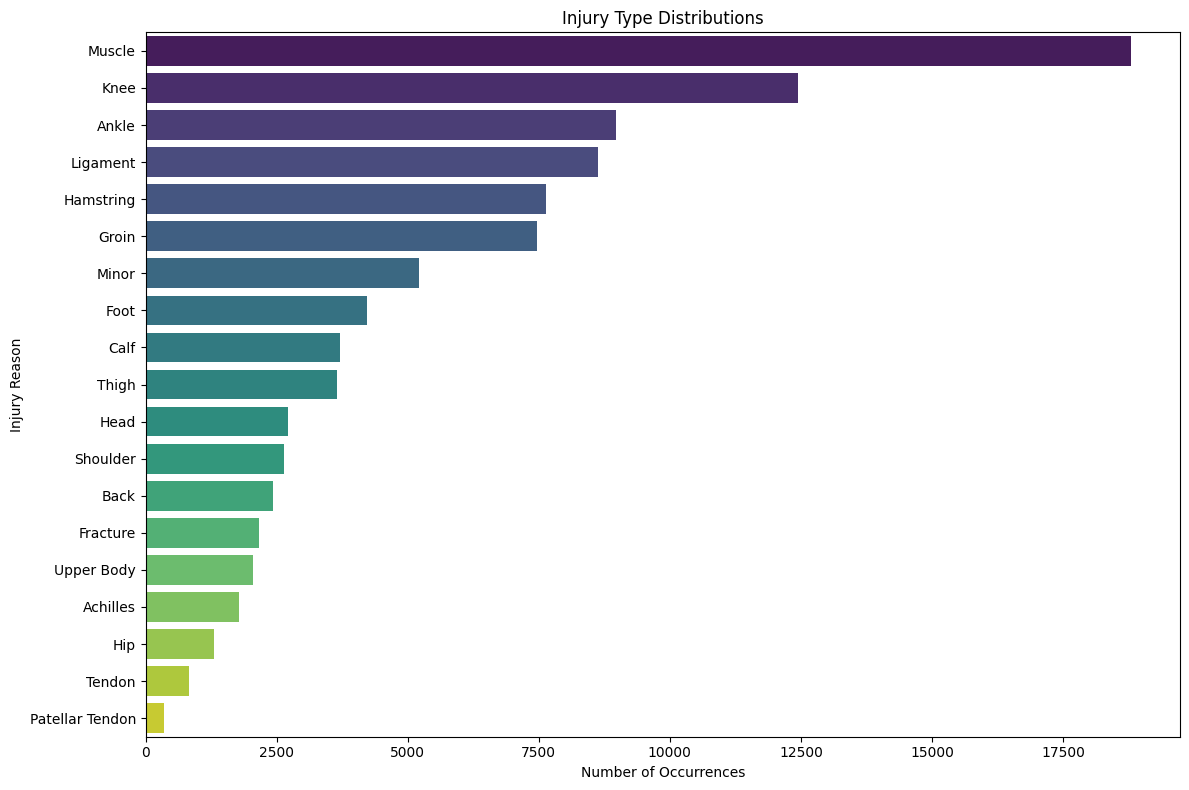

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# So at first we are going to count the occurrences of each injury reason
injury_counts = df['injury_group'].value_counts().reset_index()
injury_counts.columns = ['injury_group', 'count']

# Next up we will select the top N injury reasons for better visualization (if there are too many unique reasons)
# For now, let's plot all, but if it's too crowded, we might need to adjust.
top_n = 20 # we can adjust this number
if len(injury_counts) > top_n:
    injury_counts_plot = injury_counts.head(top_n)
    plot_title = f'Top {top_n} Injury Type Distributions'
else:
    injury_counts_plot = injury_counts
    plot_title = 'Injury Type Distributions'

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='injury_group', hue='injury_group', data=injury_counts_plot, palette='viridis', legend=False)
plt.title(plot_title)
plt.xlabel('Number of Occurrences')
plt.ylabel('Injury Reason')
plt.tight_layout()
plt.savefig('injury_type_distribution.png')
plt.show()

A few entries for height of the player was not available. So substituting the median height of players playing in same position.

In [20]:
# Replace 0 with NaN
df["height"] = df["height"].replace(0, np.nan)

# Impute with median height per position group
df["height"] = df.groupby("position_code")["height"].transform(
    lambda x: x.fillna(x.median())
)

# Fill any remaining NaNs (e.g. unknown position) with overall median
df["height"] = df["height"].fillna(df["height"].median())

In [21]:
df = df.drop(columns=["injury_group"])

Replacing NaN and None values with -1

In [22]:
df["days_since_last_injury"] = df["days_since_last_injury"].fillna(-1)

df["days_since_same_site_injury"] = df["days_since_same_site_injury"].fillna(-1)

df["age_at_injury"] = df["age_at_injury"].fillna(df["age_at_injury"].median())

df = df.dropna(subset=["days_missed"])

Creating the final dataset

In [23]:
features = ["player_id", "injury_code", "age_at_injury", "height", "position_code", "total_prior_injuries", "days_since_last_injury", "same_site_reinjury", "days_since_same_site_injury"]
target = "days_missed"

df1 = df[features + [target]]
df1.head(10)

,player_id,injury_code,age_at_injury,height,position_code,total_prior_injuries,days_since_last_injury,same_site_reinjury,days_since_same_site_injury,days_missed
0,2,0,27.0,186.0,2,0,-1.0,0,-1,27.0
1,3,1,31.0,180.0,2,0,-1.0,0,-1,19.0
2,5,2,34.0,184.0,1,0,-1.0,0,-1,22.0
3,5,3,34.0,184.0,1,1,75.0,0,-1,5.0
4,6,3,35.0,190.0,0,0,-1.0,0,-1,5.0
5,6,4,35.0,190.0,0,1,40.0,0,-1,11.0
6,6,4,36.0,190.0,0,2,449.0,1,449.0,13.0
7,7,5,24.0,179.0,2,0,-1.0,0,-1,13.0
8,7,6,25.0,179.0,2,1,355.0,0,-1,189.0
9,7,7,25.0,179.0,2,2,219.0,0,-1,41.0


##### Saving cleaned DataFrame to new CSV

In [24]:
df1.to_csv("/home/achyuth/DL_Project/Predicting-Football-Injuries-using-LSTM/Cleaned_Dataset/dataset.csv", index=False)